In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
 !ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Model
import random
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
import pickle
import pandas as pd

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [5]:
#use of pickle library to unpickle the data
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)
  
  
print(type(train_data))  
X_train,y_train=train_data['features'],train_data['labels']
X_val,y_val=val_data['features'],val_data['labels']
X_test,y_test=test_data['features'],test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0]==y_train.shape[0]),"No. of train images is not equal to no. of labels"
assert(X_val.shape[0]==y_val.shape[0]),"No. of valid images is not equal to no. of labels"
assert(X_test.shape[0]==y_test.shape[0]),"No. of test images is not equal to no. of labels"
assert(X_train.shape[1:]==(32,32,3)),"the dimension are not same"
assert(X_val.shape[1:]==(32,32,3)),"the dimension are not same"
assert(X_test.shape[1:]==(32,32,3)),"the dimension are not same"

In [8]:
data=pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

In [0]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected )- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-" + row['SignName'])
            num_of_samples.append(len(x_selected))


print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [0]:
import cv2

(32, 32, 3)
36


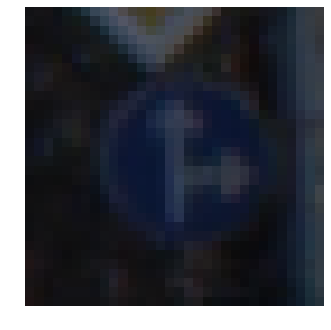

In [11]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


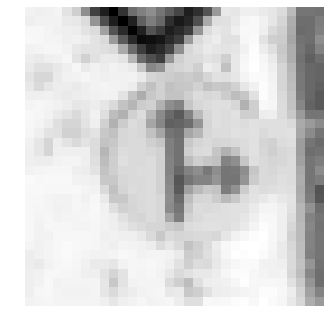

In [12]:
def grayscale(img):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img=grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


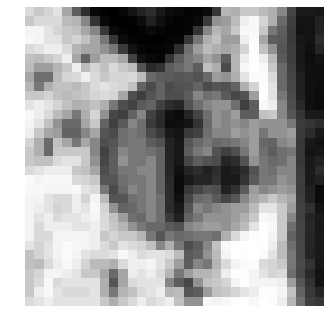

In [13]:
#histogram eqqualization
def equalize(img):
  img=cv2.equalizeHist(img)
  return img

img=equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  img=grayscale(img)
  img=equalize(img)
  #Normalization
  img=img/255
  return img

In [0]:
X_train=np.array(list(map(preprocessing,X_train)))
X_val=np.array(list(map(preprocessing,X_val)))
X_test=np.array(list(map(preprocessing,X_test)))

(34799, 32, 32)


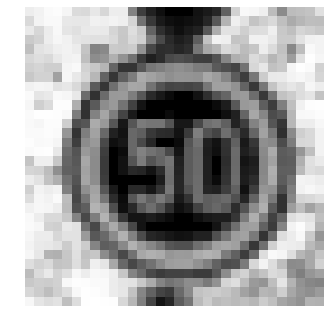

In [16]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
#Adding the depth
X_train=X_train.reshape(34799, 32, 32,1)
X_test=X_test.reshape(X_test.shape[0], 32, 32,1)
X_val=X_val.reshape(X_val.shape[0], 32, 32,1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(width_shift_range=0.1  ,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
datagen.fit(X_train)

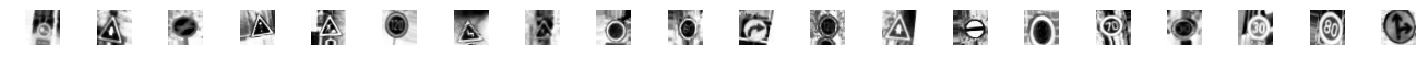

In [19]:
batches=datagen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch=next(batches)

fig,axs=plt.subplots(1,20,figsize=(20,5))
fig.tight_layout()
for i in range(20):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [20]:
 print(X_train.shape)

(34799, 32, 32, 1)


In [0]:
y_train=to_categorical(y_train,43)
y_val=to_categorical(y_val,43)
y_test=to_categorical(y_test,43)

In [0]:
def leNet_model():
  model=Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

def modified_model():
  model=Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model


In [23]:
model=modified_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [24]:
 h=model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,validation_data=(X_val,y_val),shuffle=1,verbose=1)

Epoch 1/10
2000/2000 [==============================] - 61s 31ms/step - loss: 0.9228 - acc: 0.7291 - val_loss: 0.0946 - val_acc: 0.9723
Epoch 2/10
2000/2000 [==============================] - 60s 30ms/step - loss: 0.2261 - acc: 0.9300 - val_loss: 0.0586 - val_acc: 0.9812
Epoch 3/10
2000/2000 [==============================] - 59s 30ms/step - loss: 0.1551 - acc: 0.9518 - val_loss: 0.0872 - val_acc: 0.9810
Epoch 4/10
2000/2000 [==============================] - 59s 30ms/step - loss: 0.1187 - acc: 0.9641 - val_loss: 0.0426 - val_acc: 0.9871
Epoch 5/10
2000/2000 [==============================] - 61s 30ms/step - loss: 0.0998 - acc: 0.9698 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 6/10
2000/2000 [==============================] - 60s 30ms/step - loss: 0.0873 - acc: 0.9727 - val_loss: 0.0350 - val_acc: 0.9878
Epoch 7/10
2000/2000 [==============================] - 60s 30ms/step - loss: 0.0764 - acc: 0.9764 - val_loss: 0.0435 - val_acc: 0.9884
Epoch 8/10
2000/2000 [==========================

Text(0.5,0,'ephocs')

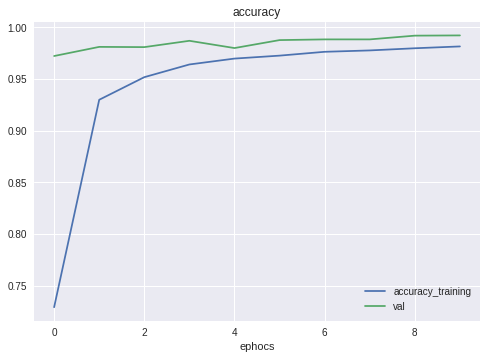

In [25]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['accuracy_training','val'])
plt.title('accuracy')
plt.xlabel('ephocs')

Text(0.5,0,'ephocs')

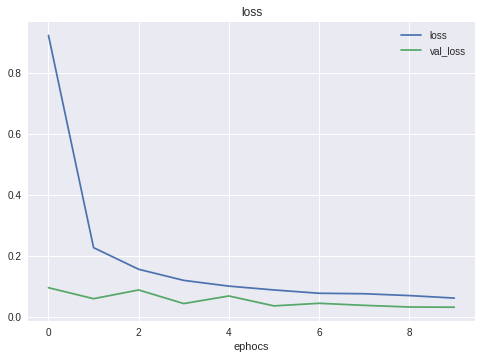

In [26]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('loss')
plt.xlabel('ephocs')

In [27]:
score=model.evaluate(X_test,y_test,verbose=0)
print("Test_score ",score[0])
print("Test_acc",score[1])

Test_score  0.1097447457604165
Test_acc 0.9764845606172642


(1300, 956)

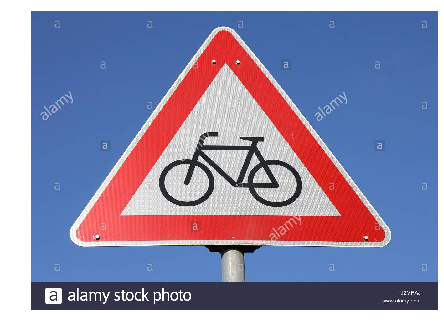

In [28]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img,)
plt.axis('off')
img.size

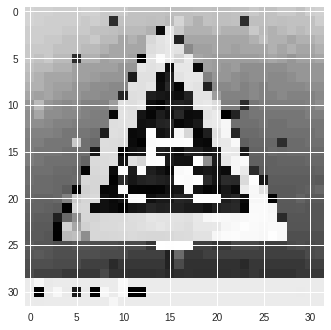

In [29]:
import cv2

img=np.asarray(img)
img=cv2.resize(img,(32,32))
img=preprocessing(img)
plt.imshow(img)

In [0]:

#Reshape reshape

img = img.reshape(1, 32, 32, 1) 

In [31]:
#testing the image
prediction=model.predict_classes(img)
print("Model prediction is:", str(prediction))

Model prediction is: [29]
